In [1]:
#Data manipulation
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
    #specific for imbalance management
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [2]:
df_original=pd.read_csv("hcvdat0.csv")
#df_original.head(10)

### 1. Data Exploration 

##### Remapping on target feature and removal of confunding data points

In [3]:
def remap_data(dataframe):
    """
    Function for remapping the categories and remove the ID of the patients
    """
    df=dataframe.copy()
    to_be_removed=df.loc[df["Category"]==df["Category"].unique()[1]].index.tolist()
    df.loc[df["Category"]==df["Category"].unique()[0],"Category"]="Healthy"
    df.loc[df["Category"]!=df["Category"].unique()[0],"Category"]="Ill"
    discarded_data=dataframe.loc[to_be_removed].drop(columns=["Unnamed: 0","Category"]).copy()
    remapped_df=df.drop(columns="Unnamed: 0").copy()
    remapped_df.drop(labels=to_be_removed, inplace=True)
    return remapped_df, discarded_data

In [4]:
data_hcv, discarded_data= remap_data(df_original)

In [5]:
#Check per controllare il DF dei dati scartati
discarded_data

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
533,47,m,22.5,124.0,79.5,46.7,2.3,6.83,4.30,170.0,345.6,58.6
534,48,m,24.9,116.9,49.2,24.3,4.9,3.44,5.25,29.0,83.0,47.8
535,49,m,21.6,42.2,9.5,10.6,2.4,3.75,3.01,64.0,38.9,44.8
536,55,m,47.3,106.0,208.8,130.6,0.8,14.80,8.08,76.0,71.6,78.3
537,71,m,14.9,69.8,19.7,95.2,9.8,13.30,2.61,9.0,7.6,47.0
538,74,m,20.3,84.0,22.8,43.0,5.7,4.91,3.19,52.0,218.3,47.8
539,59,f,19.3,208.2,325.3,146.6,6.9,5.33,4.72,32.0,295.6,53.1


In [6]:
#Check per controllare il DF dei dati utilizzati nell'analisi
data_hcv.tail()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
610,Ill,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,Ill,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
612,Ill,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
613,Ill,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0
614,Ill,59,f,36.0,NaN,100.0,80.0,12.0,9.07,5.30,67.0,34.0,68.0


In [7]:
#Check sul DF originale che non sia stato toccato
df_original.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


##### Class imbalance

<AxesSubplot:xlabel='Category', ylabel='Count'>

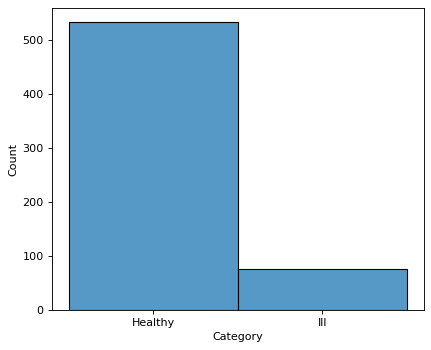

In [8]:
plt.figure(figsize=(6,5), dpi=80)
sns.histplot(data_hcv, x="Category")
#plt.savefig("classes_balance.png")

In [9]:
for cat in data_hcv["Category"].unique():
    perc=data_hcv[data_hcv["Category"]==cat]["Category"].count()/len(data_hcv)
    print(f"Percentage of data belonging to class {cat}: {perc:.2%}")

#ratio Healthy:Ill = 7:1

Percentage of data belonging to class Healthy: 87.66%
Percentage of data belonging to class Ill: 12.34%


In [10]:
#PLOTTING FUNCTIONS

#univariate boxplots
def print_boxplot(df, feature):
    sns.boxplot(x="Category", y=feature, data=df)
    #plt.savefig(f"{feature}.png")

#bivariate scatterplot 
def print_bivariate(df):
    plt.figure(figsize=(8,8), dpi=100)
    sns.pairplot(df, hue="Category")
    #plt.savefig("scatterplot.png")
    
#annotated correlation matrix
def print_correlation(df):
    corr=df.corr()
    plt.figure(figsize=(8,6), dpi=100)
    sns.heatmap(corr, cmap='OrRd', annot=True)
    #plt.savefig("correlation_matrix.png")

##### Visualization of categorical feature Sex

In [11]:
def visualize_sex_distr(data_hcv, class_label):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.pie(x=data_hcv[data_hcv["Category"]==class_label]["Sex"].value_counts(),
        colors=["skyblue","pink"], 
        labels=["Male","Female"], 
        shadow = True, 
        autopct="%1.2f%%", 
        explode = (0, 0.1),
        )
    plt.title(class_label)
    #plt.savefig(f"{class_label}.png")

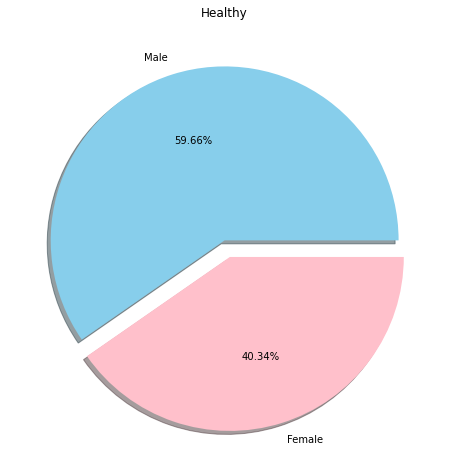

In [12]:
visualize_sex_distr(data_hcv, "Healthy")

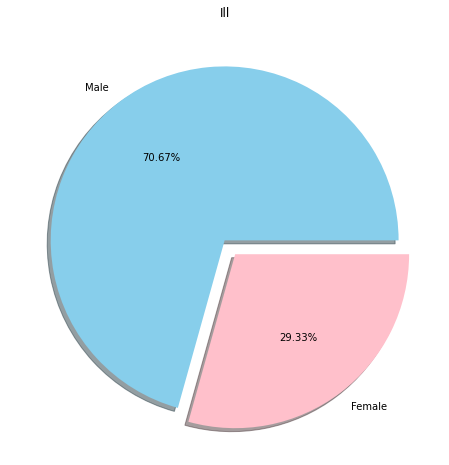

In [13]:
visualize_sex_distr(data_hcv, "Ill")

##### Visualization of numerical features

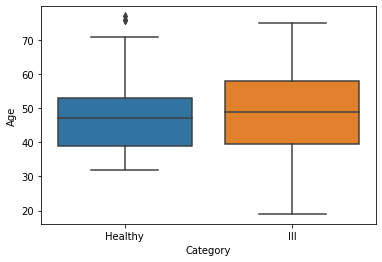

In [14]:
print_boxplot(data_hcv,"Age")

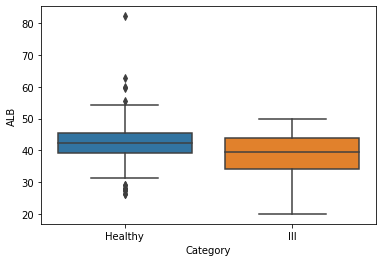

In [15]:
print_boxplot(data_hcv,"ALB")

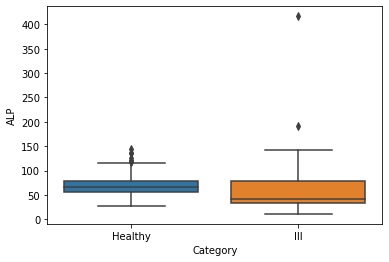

In [16]:
print_boxplot(data_hcv,"ALP")

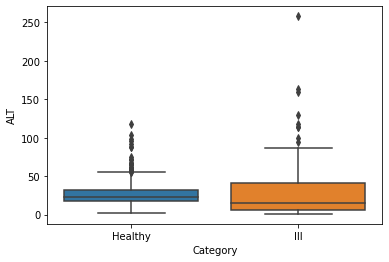

In [17]:
print_boxplot(data_hcv,"ALT")

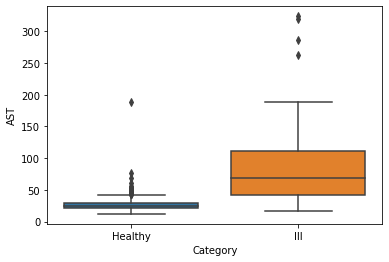

In [18]:
print_boxplot(data_hcv,"AST")

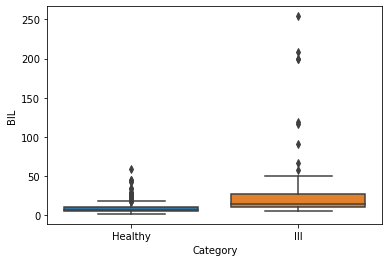

In [19]:
print_boxplot(data_hcv,"BIL")

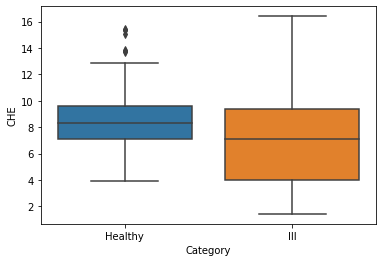

In [20]:
print_boxplot(data_hcv,"CHE")

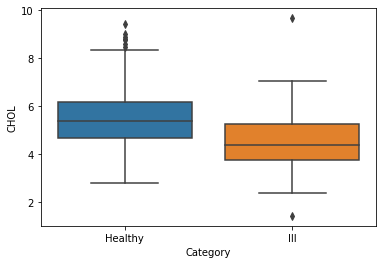

In [21]:
print_boxplot(data_hcv,"CHOL")

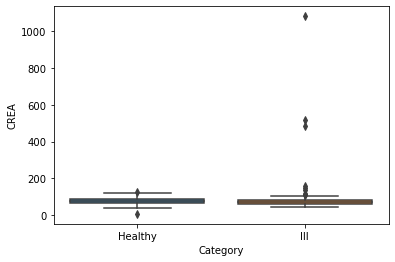

In [22]:
print_boxplot(data_hcv,"CREA")

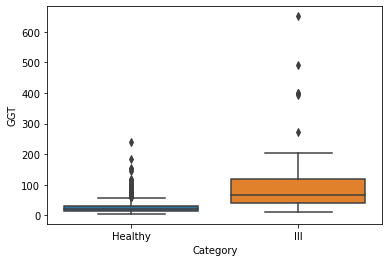

In [23]:
print_boxplot(data_hcv,"GGT")

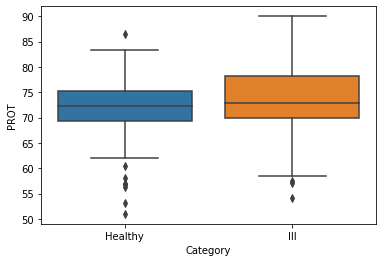

In [24]:
print_boxplot(data_hcv,"PROT")

<Figure size 800x800 with 0 Axes>

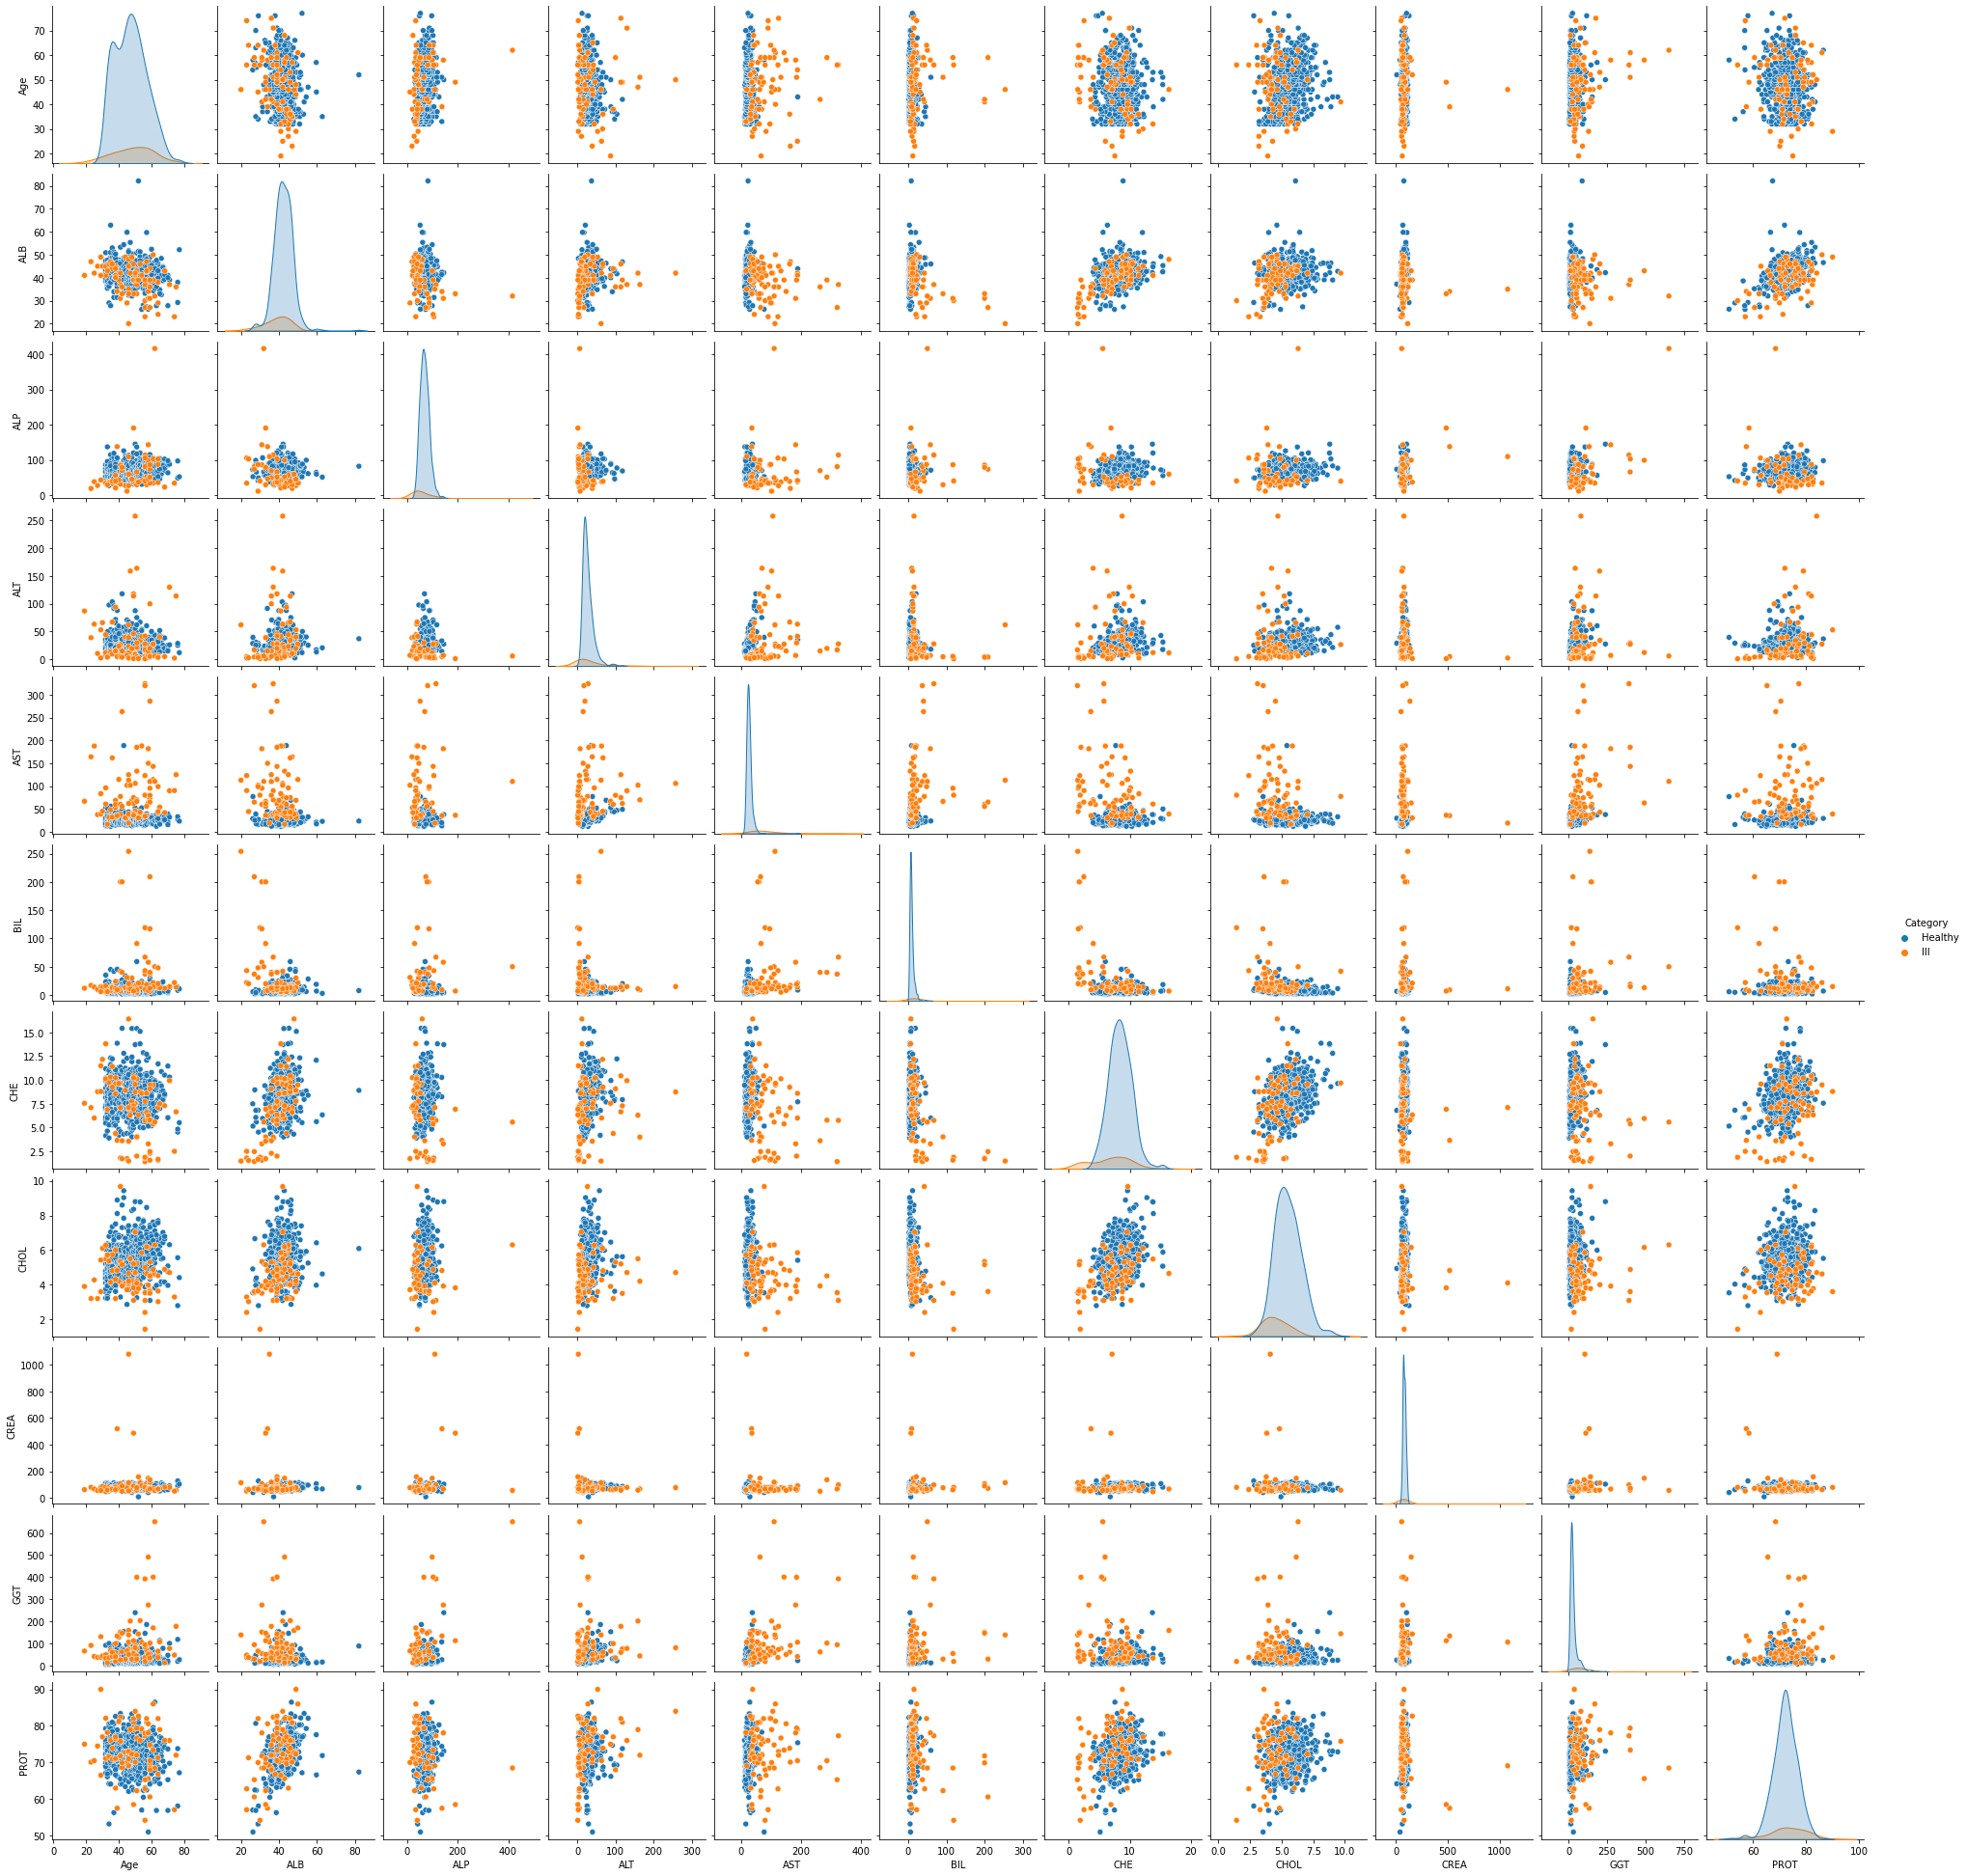

In [25]:
print_bivariate(data_hcv)

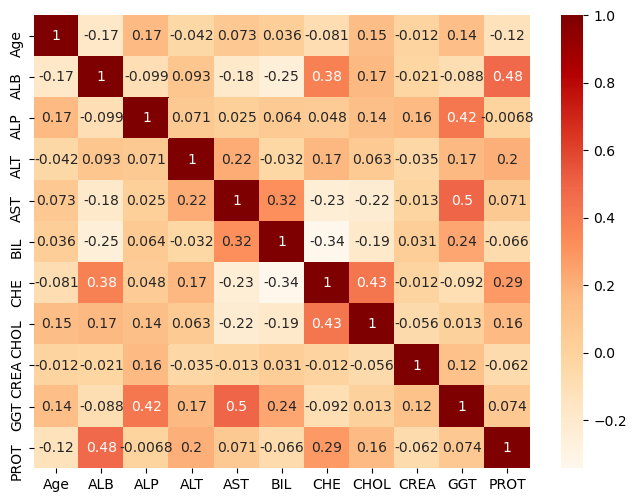

In [26]:
print_correlation(data_hcv)

### 2. Pre-Processing 

###### Factor encoding 

In [27]:
category_map= {'Healthy': 0, 'Ill': 1}
sex_map= {'m':0, 'f':1} 
data_hcv['Category'] = data_hcv.Category.map(category_map)
data_hcv['Sex'] = data_hcv.Sex.map(sex_map)

##### Filling missing value with mean

In [28]:
for col in data_hcv.drop(columns="Category").columns:
    data_hcv[col].fillna(value=data_hcv[col].mean(), inplace=True)

##### Remove outliers 

In [29]:
#Tentativi di rimozione OUTLIER

#IQR
#Z-SCORE
#A NASO

In [30]:
def remove_outliers(data_in, method, col_name=None, col_value=None):
    
    """
    This function is used to perform outliers removal accordal to the three methods presented.
    """
    
    idx_removanda=set()
    if(method=="IQR"):
        for col in data_in.drop(columns=["Sex","Category"]).columns:    
            Q1=data_in[col].quantile(.25)
            Q3=data_in[col].quantile(.75)
            IQR=Q3-Q1
            LRL=Q1-(1.5*IQR)
            URL=Q3+(1.5*IQR)
            index_list=data_hcv.loc[(data_hcv[col]<LRL)|(data_hcv[col]>URL)].index.tolist()
            for i in index_list:
                idx_removanda.add(i)
                
    elif(method=="zscore"):
        #first transform data in z: WARNING DO TO NOT MODIFY ORIGINAL DF, TAKE A COPY
        new_df=data_hcv.drop(columns=["Sex","Category"]).copy()
        for col in new_df.columns:
            new_df[col]=(data_hcv[col]-data_hcv[col].mean())/data_hcv[col].std()
        for col in new_df.columns: 
            index_list=new_df.loc[(new_df[col]<-3*new_df[col].std())|(new_df[col]>3*new_df[col].std())].index.tolist()
            for i in index_list:
                idx_removanda.add(i)
                
    elif(method=='manual'):
        print(col_value)
        index_list=data_hcv.loc[data_hcv[col_name]>col_value].index.tolist()
        for i in index_list:
            idx_removanda.add(i)
    else:
        return
    
    
    data_out=data_in.drop(labels=list(idx_removanda)).copy()
    
    remaining_h=(data_out["Category"]==0).sum()/(data_hcv["Category"]==0).sum()
    print(f"Remaining data belonging to class Healthy: {remaining_h:.2%}")
    remaining_i=(data_out["Category"]==1).sum()/(data_hcv["Category"]==1).sum()
    print(f"Remaining data belonging to class Ill: {remaining_i:.2%}")
    
    return data_out 

In [31]:
#some check on the dataset before the removal of outliers
#data_hcv[data_hcv["Category"]==1]

In [32]:
data_out_iqr=remove_outliers(data_hcv,"IQR")

Remaining data belonging to class Healthy: 80.49%
Remaining data belonging to class Ill: 17.33%


In [33]:
data_out_zscore=remove_outliers(data_hcv,"zscore")

Remaining data belonging to class Healthy: 95.31%
Remaining data belonging to class Ill: 44.00%


In [34]:
#Check that after z-scoring the original DF is still un-standardized
data_hcv.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [35]:
data_out_manual=remove_outliers(data_hcv,"manual","ALB",80)
data_out_manual=remove_outliers(data_out_manual,"manual","ALP",300)
#warning, in this chain the next input df MUST BE the previous output df --> functioning already checked!

80
Remaining data belonging to class Healthy: 99.81%
Remaining data belonging to class Ill: 100.00%
300
Remaining data belonging to class Healthy: 99.81%
Remaining data belonging to class Ill: 98.67%


In [36]:
data_out_manual=remove_outliers(data_out_manual,"manual","CREA",600)

600
Remaining data belonging to class Healthy: 99.81%
Remaining data belonging to class Ill: 97.33%


In [37]:
#re-using the previous name for the dataframe
data_hcv=data_out_manual

In [38]:
len(data_hcv)

605

##### From Dataframe to Matrices and Training-Test split

In [39]:
X=data_hcv.iloc[:,1:].values
y=data_hcv.Category.values

#Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [40]:
#To confirm that the proportion are kept 
print("TRAINING SET:")
print("Ill: ",(y_train==1).sum())
print("Healthy: ",(y_train==0).sum())
print("RATIO: ",(y_train==1).sum()/(y_train==0).sum())
print("\nTEST SET:")
print("Ill: ",(y_test==1).sum())
print("Healthy: ",(y_test==0).sum())
print("RATIO: ",(y_test==1).sum()/(y_test==0).sum())

TRAINING SET:
Ill:  51
Healthy:  372
RATIO:  0.13709677419354838

TEST SET:
Ill:  22
Healthy:  160
RATIO:  0.1375


### Dimensionality Reduction - PCA Exploration

In [41]:
sc= StandardScaler()
sc.fit(X_train)
pca=PCA()

X_train_std=sc.transform(X_train)

X_train_pca=pca.fit_transform(X_train_std)
explained_var_pca=pca.explained_variance_ratio_

#Visualize 
def visualize_PCA(explained_var_pca):
    """
    This function plots the individual explained variances associated to the PCs and their cumulative sum.
    """
    #Eigenvalues cumulative sum
    cum_sum_eigenvalues=np.cumsum(explained_var_pca)
    
    #Plotting
    plt.bar(range(0,len(explained_var_pca)), explained_var_pca, alpha=0.5, align="center", label="Individual Explained Variance")
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where="mid", label="Cumulative explained variance")
    plt.ylabel('Explained variance ratio')
    plt.xlabel("Principal component")
    plt.legend(loc="best")
    plt.tight_layout()
    #plt.savefig("PCA_tot.png")
    return

#Partial cumulative sum
def variance_with_n_components(n):
    """
    This function returns the amount of explained variance associated to the first n PCs
    """
    tot=0
    for i in range(n+1):
        tot+=explained_var_pca[i]
    return tot

#List all the partial cumulative sums
def preserved_variance_listed(exp_var_pca):
    """
    This function returns the progressive cumulative sum of the variance explained
    """
    for i in range(len(exp_var_pca)):
        print(f"Preserved variance with {i+1} components: {variance_with_n_components(i):.2%}")
        


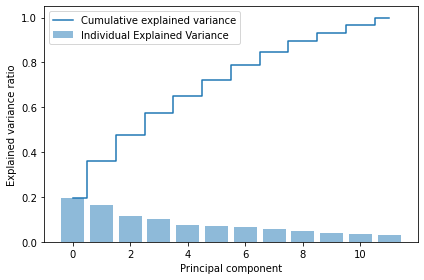

In [42]:
visualize_PCA(explained_var_pca)

In [43]:
preserved_variance_listed(explained_var_pca)

Preserved variance with 1 components: 19.50%
Preserved variance with 2 components: 36.11%
Preserved variance with 3 components: 47.53%
Preserved variance with 4 components: 57.57%
Preserved variance with 5 components: 65.06%
Preserved variance with 6 components: 72.22%
Preserved variance with 7 components: 78.71%
Preserved variance with 8 components: 84.61%
Preserved variance with 9 components: 89.56%
Preserved variance with 10 components: 93.31%
Preserved variance with 11 components: 96.80%
Preserved variance with 12 components: 100.00%


### 3. Model Selection

#### Decision Tree

In [44]:
pipeline=imbpipeline(steps=[
                           ['scaler', StandardScaler()],
                           ['smote', SMOTE(random_state=42)],
                           ['classifier', DecisionTreeClassifier(random_state=42)]])

stratified_kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid={'classifier__criterion':['gini','entropy'],
           'classifier__max_features':["sqrt","auto"]}

grid_search=GridSearchCV(estimator=pipeline,
                        param_grid=param_grid,
                        scoring='f1',
                        cv=stratified_kfold,
                        n_jobs=-1)

grid_search.fit(X_train, y_train)
dt=grid_search.best_estimator_
grid_search.best_params_, grid_search.best_score_

({'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt'},
 0.7641581027667985)

#### Random Forest

In [45]:
pipeline=imbpipeline(steps=[
                           ['scaler', StandardScaler()],
                           ['smote', SMOTE(random_state=42)],
                           ['classifier', RandomForestClassifier(random_state=42)]])

stratified_kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid={'classifier__n_estimators':[100,200,300],
            'classifier__criterion':['gini','entropy'],
            'classifier__max_features':["sqrt","auto"]}

grid_search=GridSearchCV(estimator=pipeline,
                        param_grid=param_grid,
                        scoring='f1',
                        cv=stratified_kfold,
                        n_jobs=-1)

grid_search.fit(X_train, y_train)
rf=grid_search.best_estimator_
grid_search.best_params_, grid_search.best_score_

({'classifier__criterion': 'entropy',
  'classifier__max_features': 'sqrt',
  'classifier__n_estimators': 200},
 0.879009116995387)

#### Logistic Regression

In [46]:
pipeline3=imbpipeline(steps=[
                           ['scaler', StandardScaler()],
                           ['smote', SMOTE(random_state=42)],
                           ['classifier', LogisticRegression(random_state=42, max_iter=1000)]])

stratified_kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid={'classifier__C':[0.001,0.01,0.1,1,10,100,1000],
           'classifier__class_weight':[None,"balanced"]}

grid_search=GridSearchCV(estimator=pipeline3,
                        param_grid=param_grid,
                        scoring='f1',
                        cv=stratified_kfold,
                        n_jobs=-1)

grid_search.fit(X_train, y_train)
lr=grid_search.best_estimator_
grid_search.best_params_ , grid_search.best_score_

({'classifier__C': 1, 'classifier__class_weight': None}, 0.8218897044984)

#### SVM

In [47]:
pipeline=imbpipeline(steps=[
                           ['scaler', StandardScaler()],
                           ['PCA', PCA()],
                           ['smote', SMOTE(random_state=42)],
                           ['classifier', SVC(random_state=42)]])

stratified_kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid={'classifier__kernel':['linear', 'poly', 'rbf'],
           'classifier__C':[0.01, 0.1, 1, 10, 100],
           'PCA__n_components':[9,10,11,12]}

grid_search=GridSearchCV(estimator=pipeline,
                        param_grid=param_grid,
                        scoring='f1',
                        cv=stratified_kfold,
                        n_jobs=-1)

grid_search.fit(X_train, y_train)
svm=grid_search.best_estimator_
grid_search.best_params_, grid_search.best_score_

({'PCA__n_components': 11, 'classifier__C': 1, 'classifier__kernel': 'rbf'},
 0.8868851971826801)

### Testing

Decision Tree
accuracy : 92.86%
precision : 68.18%
recall : 71.43%
f1 : 69.77%


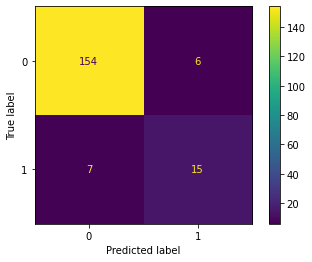

--------------------------------------------------
Random Forest
accuracy : 98.90%
precision : 90.91%
recall : 100.00%
f1 : 95.24%


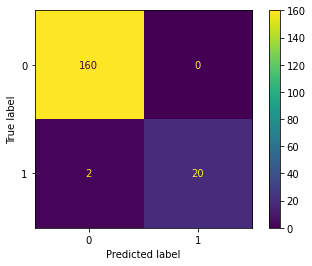

--------------------------------------------------
Logistic Regression
accuracy : 95.60%
precision : 81.82%
recall : 81.82%
f1 : 81.82%


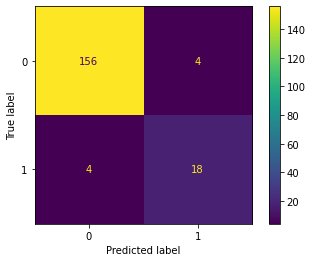

--------------------------------------------------
SVM
accuracy : 97.80%
precision : 90.91%
recall : 90.91%
f1 : 90.91%


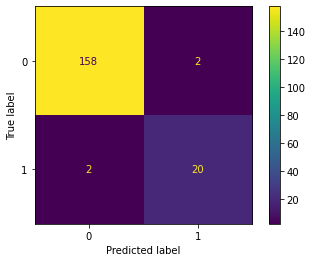

--------------------------------------------------


In [48]:
models=[dt, rf, lr, svm]
model_names=["Decision Tree", "Random Forest", "Logistic Regression", "SVM"]
metrics={'accuracy': accuracy_score,
         'precision':precision_score, 
         'recall': recall_score, 
         'f1':f1_score}

#creating a dataframe for plotting the results afterwards
results=pd.DataFrame(index=model_names, columns=list(metrics.keys()))

for model,model_name in zip(models,model_names):
    print(model_name)
    y_hat=model.predict(X_test)
    for m in metrics.keys():
        results[m][model_name]=metrics[m](y_hat,y_test)
        print(f"{m} : {metrics[m](y_hat,y_test):.2%}")    
    cm = confusion_matrix(y_test, y_hat, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=model.classes_)
    disp.plot()
    plt.show()
    #plt.savefig(f"{model_name}_confusionmatrix.png")
    print("-"*50)

In [49]:
#y_hat

##### Plotting the results of the training

In [50]:
def plot_results(df):
    """
    This functions plot the results of the testing, with the different used metrics.
    """
    df.plot.bar(figsize=(8,5) )
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.grid()
    plt.savefig("training_errors.png")

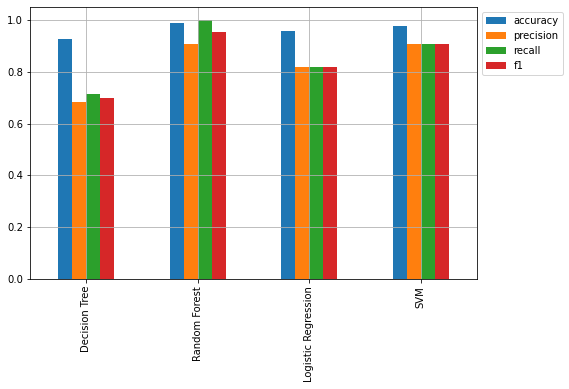

In [51]:
plot_results(results)

##### Interpretability : Decision Tree and Random Forest

Decision Tree : visualization and feature importance

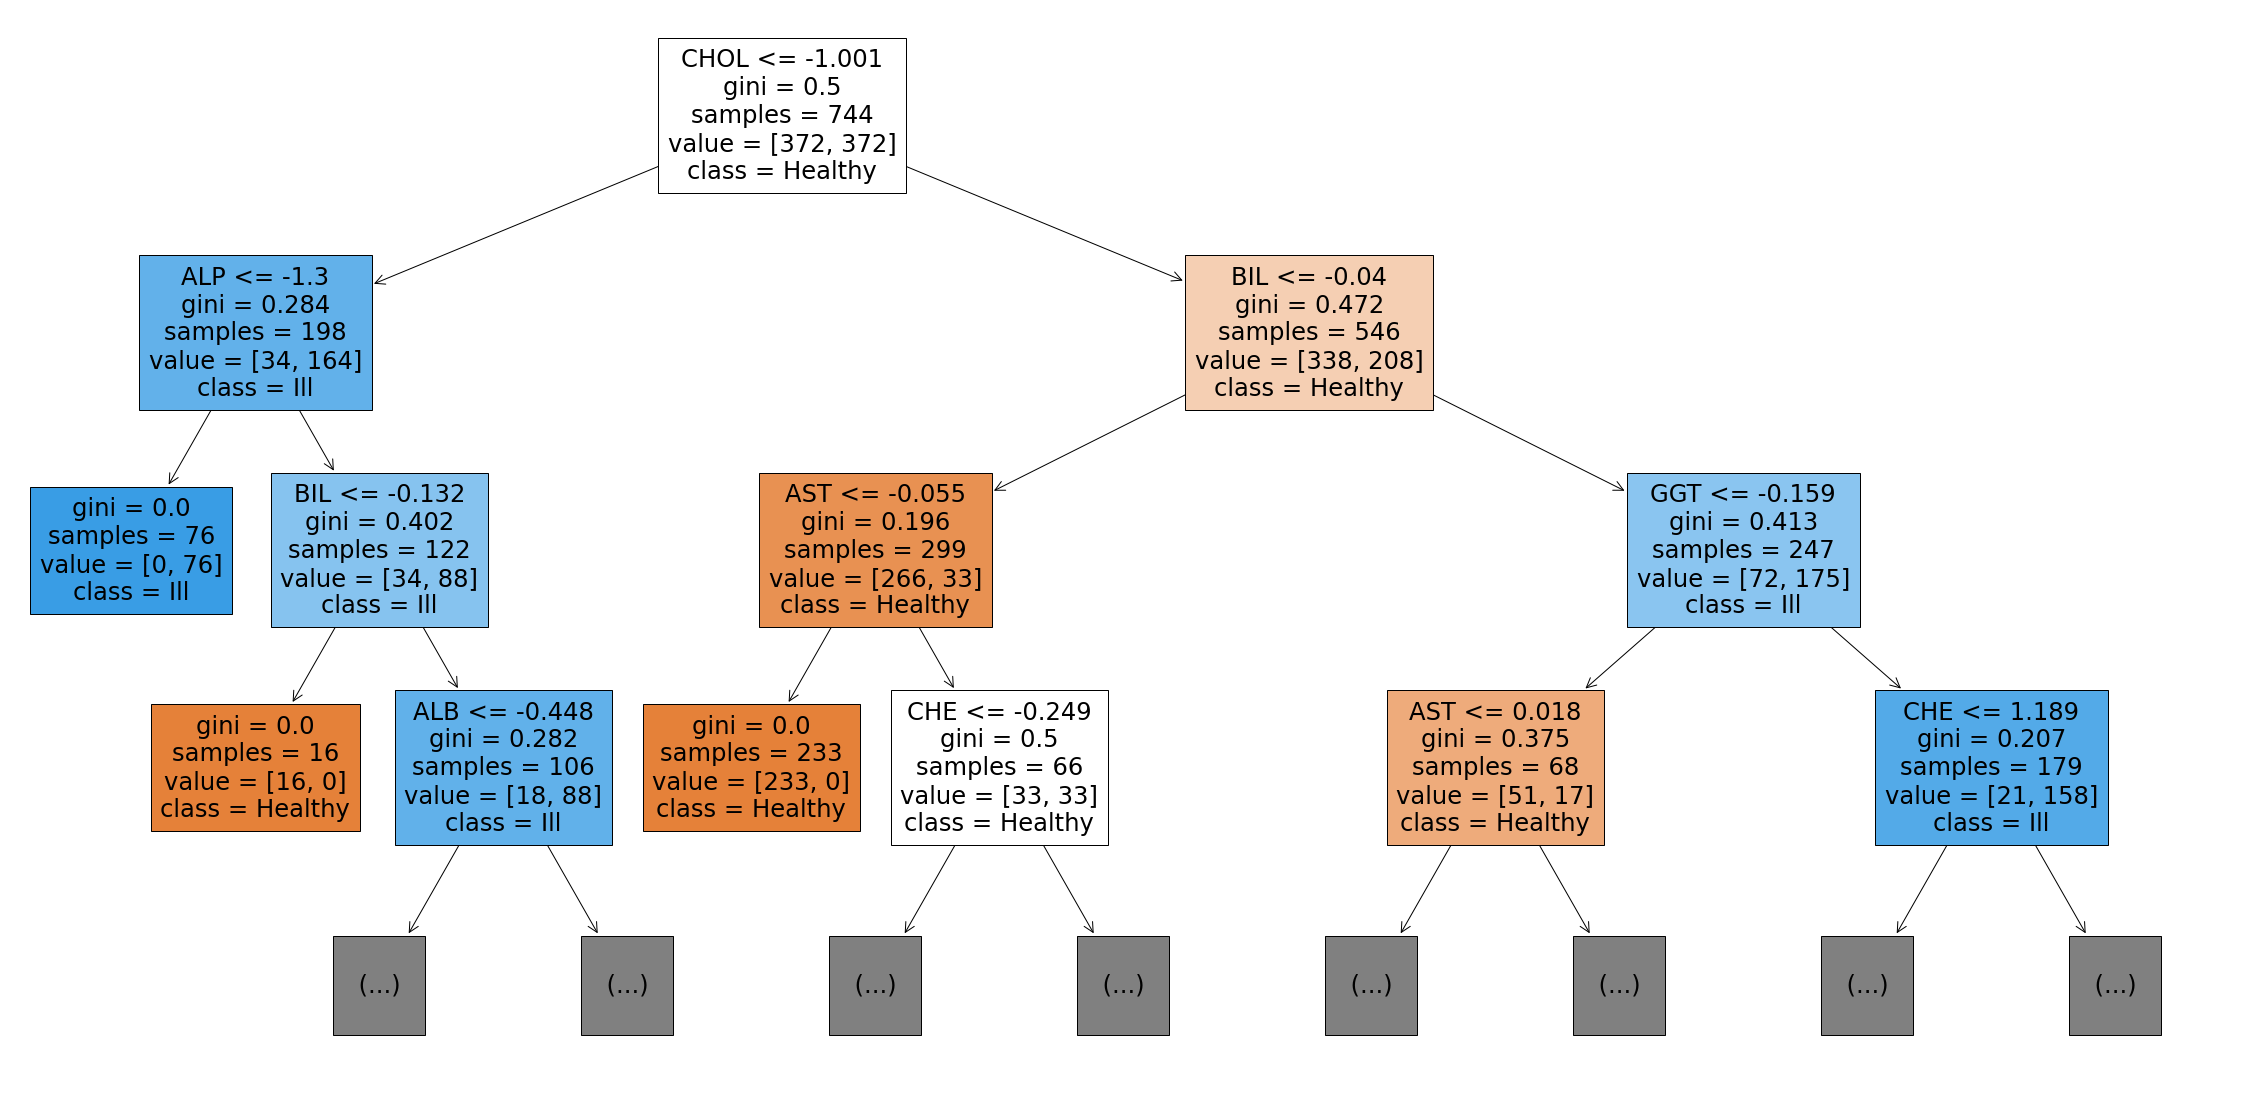

<Figure size 432x288 with 0 Axes>

In [52]:
#dt[2] takes from pipeline contained in "dt" the third element, that is to say the classifier
plt.figure(figsize=(40,20))
plot_tree(dt[2], max_depth=3, filled=True, class_names=["Healthy","Ill"],feature_names=data_hcv.drop(columns="Category").columns)
plt.show()
plt.savefig("decision_tree.png")

#Sull'arancionino ho healthy, su azzurrino ill

In [53]:
def plot_feature_importance(importance,names,model_type):
    
    """
    This function print a plot of the computed feature importances for the selected model
    """

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(y=fi_df['feature_importance'], x=fi_df['feature_names'], )
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.ylabel('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE NAMES')
    plt.savefig(f"importance_{model_type}.png")

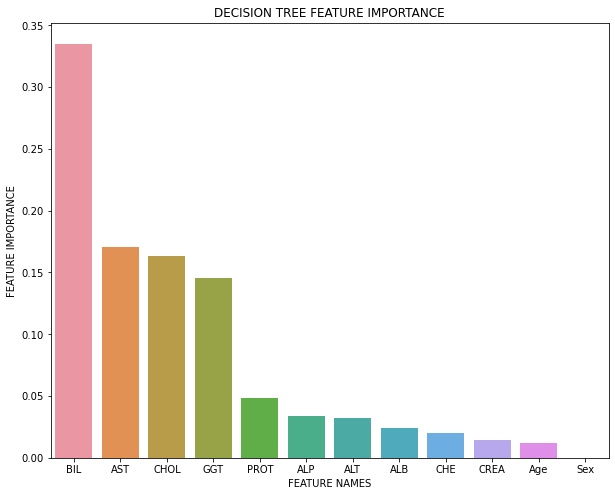

In [54]:
plot_feature_importance(dt[2].feature_importances_, data_hcv.drop(columns="Category").columns, "DECISION TREE ")

Random Forest: feature importance

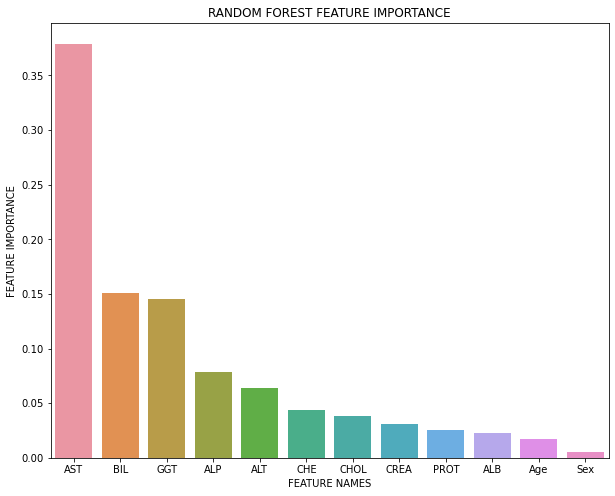

In [55]:
plot_feature_importance(rf[2].feature_importances_, data_hcv.drop(columns="Category").columns, "RANDOM FOREST ")

### 4. Extra chapter: prediction on discarded "0s= Suspect blood donor" records

In [56]:
#Check that there are no missing values
print(discarded_data)

#Fast preprocessing
discarded_data['Sex']=discarded_data.Sex.map(sex_map)

to_be_predicted=discarded_data.values

     Age Sex   ALB    ALP    ALT    AST  BIL    CHE  CHOL   CREA    GGT  PROT
533   47   m  22.5  124.0   79.5   46.7  2.3   6.83  4.30  170.0  345.6  58.6
534   48   m  24.9  116.9   49.2   24.3  4.9   3.44  5.25   29.0   83.0  47.8
535   49   m  21.6   42.2    9.5   10.6  2.4   3.75  3.01   64.0   38.9  44.8
536   55   m  47.3  106.0  208.8  130.6  0.8  14.80  8.08   76.0   71.6  78.3
537   71   m  14.9   69.8   19.7   95.2  9.8  13.30  2.61    9.0    7.6  47.0
538   74   m  20.3   84.0   22.8   43.0  5.7   4.91  3.19   52.0  218.3  47.8
539   59   f  19.3  208.2  325.3  146.6  6.9   5.33  4.72   32.0  295.6  53.1


In [57]:
def attach_the_predictions(df, predictions):
    """
    Reconstruct the DF with the predictions for the discarded records.
    """
    inverse_map= {0:'Healthy', 1:'Ill'} 
    df['Category']=predictions
    df['Category'] = df.Category.map(inverse_map)
    
    print(df)

Random Forest

In [58]:
pred_rf=rf.predict(to_be_predicted)
attach_the_predictions(discarded_data, pred_rf)

     Age  Sex   ALB    ALP    ALT    AST  BIL    CHE  CHOL   CREA    GGT  \
533   47    0  22.5  124.0   79.5   46.7  2.3   6.83  4.30  170.0  345.6   
534   48    0  24.9  116.9   49.2   24.3  4.9   3.44  5.25   29.0   83.0   
535   49    0  21.6   42.2    9.5   10.6  2.4   3.75  3.01   64.0   38.9   
536   55    0  47.3  106.0  208.8  130.6  0.8  14.80  8.08   76.0   71.6   
537   71    0  14.9   69.8   19.7   95.2  9.8  13.30  2.61    9.0    7.6   
538   74    0  20.3   84.0   22.8   43.0  5.7   4.91  3.19   52.0  218.3   
539   59    1  19.3  208.2  325.3  146.6  6.9   5.33  4.72   32.0  295.6   

     PROT Category  
533  58.6  Healthy  
534  47.8  Healthy  
535  44.8  Healthy  
536  78.3  Healthy  
537  47.0  Healthy  
538  47.8  Healthy  
539  53.1  Healthy  


Logistic Regression 

In [59]:
pred_lr=lr.predict(to_be_predicted)
attach_the_predictions(discarded_data, pred_lr)
probabilita=lr.predict_proba(to_be_predicted)
print(probabilita)
for c in probabilita:
    entropy=-np.sum(c*np.log2(c))
    print(entropy)

     Age  Sex   ALB    ALP    ALT    AST  BIL    CHE  CHOL   CREA    GGT  \
533   47    0  22.5  124.0   79.5   46.7  2.3   6.83  4.30  170.0  345.6   
534   48    0  24.9  116.9   49.2   24.3  4.9   3.44  5.25   29.0   83.0   
535   49    0  21.6   42.2    9.5   10.6  2.4   3.75  3.01   64.0   38.9   
536   55    0  47.3  106.0  208.8  130.6  0.8  14.80  8.08   76.0   71.6   
537   71    0  14.9   69.8   19.7   95.2  9.8  13.30  2.61    9.0    7.6   
538   74    0  20.3   84.0   22.8   43.0  5.7   4.91  3.19   52.0  218.3   
539   59    1  19.3  208.2  325.3  146.6  6.9   5.33  4.72   32.0  295.6   

     PROT Category  
533  58.6      Ill  
534  47.8  Healthy  
535  44.8  Healthy  
536  78.3      Ill  
537  47.0      Ill  
538  47.8      Ill  
539  53.1      Ill  
[[1.31300468e-03 9.98686995e-01]
 [9.99883124e-01 1.16875861e-04]
 [9.76755944e-01 2.32440565e-02]
 [2.52880557e-01 7.47119443e-01]
 [6.75498246e-02 9.32450175e-01]
 [3.88653284e-02 9.61134672e-01]
 [4.38539467e-02 9.561460

SVM

In [60]:
pred_svm=svm.predict(to_be_predicted)
attach_the_predictions(discarded_data, pred_svm)

     Age  Sex   ALB    ALP    ALT    AST  BIL    CHE  CHOL   CREA    GGT  \
533   47    0  22.5  124.0   79.5   46.7  2.3   6.83  4.30  170.0  345.6   
534   48    0  24.9  116.9   49.2   24.3  4.9   3.44  5.25   29.0   83.0   
535   49    0  21.6   42.2    9.5   10.6  2.4   3.75  3.01   64.0   38.9   
536   55    0  47.3  106.0  208.8  130.6  0.8  14.80  8.08   76.0   71.6   
537   71    0  14.9   69.8   19.7   95.2  9.8  13.30  2.61    9.0    7.6   
538   74    0  20.3   84.0   22.8   43.0  5.7   4.91  3.19   52.0  218.3   
539   59    1  19.3  208.2  325.3  146.6  6.9   5.33  4.72   32.0  295.6   

     PROT Category  
533  58.6      Ill  
534  47.8  Healthy  
535  44.8  Healthy  
536  78.3      Ill  
537  47.0      Ill  
538  47.8      Ill  
539  53.1      Ill  


Decision Tree

In [61]:
pred_dt=dt.predict(to_be_predicted)
attach_the_predictions(discarded_data, pred_dt)

     Age  Sex   ALB    ALP    ALT    AST  BIL    CHE  CHOL   CREA    GGT  \
533   47    0  22.5  124.0   79.5   46.7  2.3   6.83  4.30  170.0  345.6   
534   48    0  24.9  116.9   49.2   24.3  4.9   3.44  5.25   29.0   83.0   
535   49    0  21.6   42.2    9.5   10.6  2.4   3.75  3.01   64.0   38.9   
536   55    0  47.3  106.0  208.8  130.6  0.8  14.80  8.08   76.0   71.6   
537   71    0  14.9   69.8   19.7   95.2  9.8  13.30  2.61    9.0    7.6   
538   74    0  20.3   84.0   22.8   43.0  5.7   4.91  3.19   52.0  218.3   
539   59    1  19.3  208.2  325.3  146.6  6.9   5.33  4.72   32.0  295.6   

     PROT Category  
533  58.6      Ill  
534  47.8  Healthy  
535  44.8  Healthy  
536  78.3  Healthy  
537  47.0      Ill  
538  47.8  Healthy  
539  53.1  Healthy  
